# 单向波动差多市场择时的投资策略
根据国信证券研报 - 《20151022 基于相对强弱下单向波动差值应用》
基于对波动率的分解， 可以对市场的走势进行择时判断。 


In [103]:
import OneSideVolatilityStrategy as st
import odo
import pandas as pd
import matplotlib
%matplotlib inline

In [166]:
#df_price = odo.odo('index_sh.csv', pd.DataFrame)
import Quandl
df_price = Quandl.get("YAHOO/INDEX_SSEC", trim_start="1970-01-01")
df_price = df_price.loc['2004-04-20'::]

In [232]:
def AbsoluteVol(data, n_ma=60) :
    df = data
    df['po_std'] = df['High'] - df['Open']
    df['ne_std'] = df['Open'] - df['Low']
    df['delta_std'] = df['po_std'] - df['ne_std']
    df['ma_delta_std'] = pd.rolling_mean(df['delta_std'], n_ma)

    df = df.dropna()
    return df

## 策略 1.1: 使用单向波动差对市场进行择时

In [235]:
def PosNegVolatilityStrategy(df_price, n_vol=20, n_ma=60) :
    df_spread = df_price['Close'] - df_price['Open']

    # calculate the returns
    df_ret_co = df_price['Close'] / df_price['Open'] -1
    df_ret_cc = df_price['Close'] / df_price['Close'].shift(1) -1
    df_ret_oo = df_price['Open'] / df_price['Open'].shift(1) - 1
    df_ret_oc = df_price['Open'] / df_price['Close'].shift(1) - 1
    
    # calculate the vol
    df_spread_vol = AbsoluteVol(df_price, n_ma)
    #df_ret_co_vol = GetOneSideVol(df_ret_co, n_ma)
    
    # strategy 1: using the daily Close-Open spread
    signal = pd.DataFrame()
    signal['ma'] = (df_spread_vol['ma_delta_std'] > 0) * 1 \
    #    + (df_spread_vol['ma_delta_std'] < 0) * -1
    signal['cross'] = (df_spread_vol['delta_std'] > df_spread_vol['ma_delta_std']) * 1 \
    #    +  (df_spread_vol['delta_std'] < df_spread_vol['ma_delta_std']) * -1
        
    ret = pd.DataFrame()
    ret.index.tz = None
    ret['cc'] = df_ret_cc
    ret['oo'] = df_ret_oo
    ret['co'] = df_ret_co
    ret['oc'] = df_ret_oc
    ret['cross_cc'] = signal['cross'].shift(1) * df_ret_cc
    ret['cross_co'] = signal['cross'].shift(1) * df_ret_co
    ret['cross_oo'] = signal['cross'].shift(1) * df_ret_oo
    ret['ma_cc'] = signal['ma'].shift(1) * df_ret_cc
    ret['ma_co'] = signal['ma'].shift(1) * df_ret_co
    ret['ma_oo'] = signal['ma'].shift(2) * df_ret_oo
    ret = ret.dropna()
    return ret

ret = PosNegVolatilityStrategy(df_price)

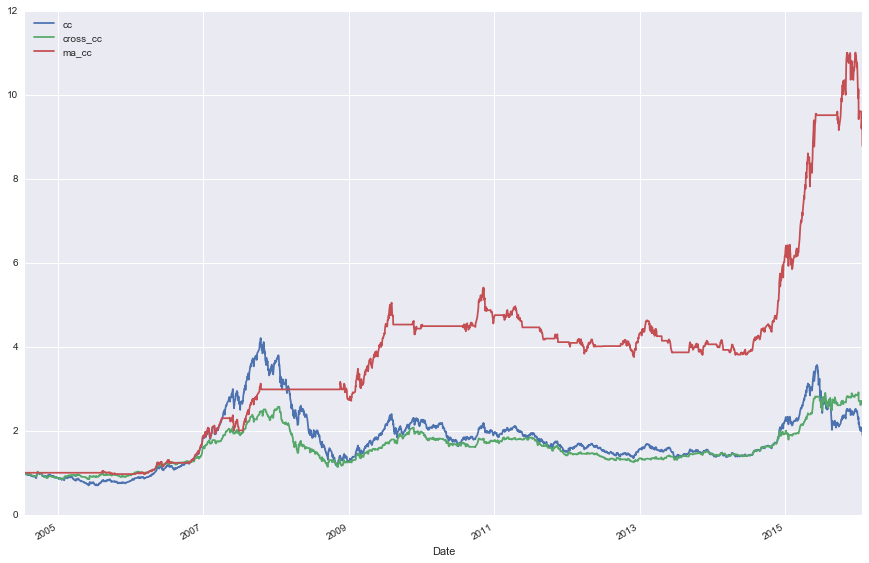

In [236]:
(1+ret[['cc', 'cross_cc', 'ma_cc']]).cumprod().plot(figsize=[15,10])

## 策略 1.2: 使用相对强弱RPS指标择时：

RPS测量市场是否处于强势：RPS取值[0, 1]之间， 1为最强。 

RPS为市场当前价格与一年250日内最低价之差， 与250年最高最低价之比。 由于指标噪音比较高， 取值10日均线。 

In [170]:
df_close = df_price['Close']

def RPS(price, n_days = 250, n_ma = 10) :
    '''
    '''
    spread = price - price.shift(n_days)
    max_price = pd.rolling_max(price, n_days)
    min_price = pd.rolling_min(price, n_days)

    rps = pd.DataFrame()
    rps['value'] = (price - min_price) / (max_price - min_price)
    rps['ma'] = pd.rolling_mean(rps['value'], n_ma)
    return rps

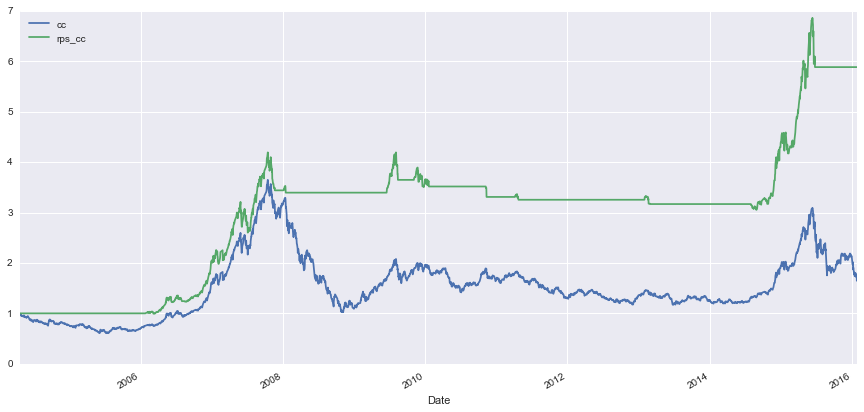

In [194]:
def RPSStrategy(df_price, n_days = 250, n_ma=1) :
    # calculate the returns
    df_ret_co = df_price['Close'] / df_price['Open'] -1
    df_ret_cc = df_price['Close'] / df_price['Close'].shift(1) -1
    df_ret_oo = df_price['Open'] / df_price['Open'].shift(1) - 1
    df_ret_oc = df_price['Open'] / df_price['Close'].shift(1) - 1
    
    # calculate the RPS
    df_rps = RPS(df_price['Close'], n_days, n_ma)
    
    # strategy 1: using the daily Close-Open spread
    signal = pd.DataFrame()
    signal['rps'] = (df_rps['ma'] > 0.8) * 1 \
       # + (df_rps['ma'] < 0.2) * -1
    
        
    ret = pd.DataFrame()
    ret.index.tz = None
    ret['cc'] = df_ret_cc
    #ret['oo'] = df_ret_oo
    #ret['co'] = df_ret_co
    #ret['oc'] = df_ret_oc
    ret['rps_cc'] = signal['rps'].shift(1) * df_ret_cc
    #ret['rps_co'] = signal['rps'].shift(1) * df_ret_co
    ret = ret.dropna()
    return ret

ret = RPSStrategy(df_price)
(1+ret).cumprod().plot(figsize=[15,7])

## 策略 1.3: 将RPS与单边波动结合

策略步骤简介:
    1. 计算相应指数相对强弱RPS
    2. 计算相应指数上行波动率、下行波动率，并计算二者差值
    3. 计算当天波动率差值的移动均值（天数由RPS值确定、RPS值越大相就取的天数越多
    4. 观察前一天的(波动率差值的移动均值)，如为正就保持持有（或卖入）、否则就保持空仓（或卖出）。
    5. 注：考虑交易成本 

In [283]:
def CombinedStrategy(df_price) :
    df_spread = df_price['Close'] - df_price['Open']
    
    # calculate the returns
    df_ret_co = df_price['Close'] / df_price['Open'] -1
    df_ret_cc = df_price['Close'] / df_price['Close'].shift(1) -1
    df_ret_oo = df_price['Open'] / df_price['Open'].shift(1) - 1
    df_ret_oc = df_price['Open'] / df_price['Close'].shift(1) - 1
    
    # calculate the RPS
    df_rps = RPS(df_price['Close'])
    
    # calculate the one side vol
    n_ma = int((1-df_rps['ma'].tail(1)) * 60) + 1
    print (n_ma)
    df_vol = AbsoluteVol(df_price, n_ma)
    
    # strategy 1: using the daily Close-Open spread
    signal = pd.DataFrame()
    signal['ma'] = (df_vol['ma_delta_std'] > 0) * 1 
    signal['cross'] = (df_vol['delta_std'] > df_vol['ma_delta_std']) * 1 
        
    ret = pd.DataFrame()
    ret.index.tz = None
    ret['cc'] = df_ret_cc
    ret['ma_cc'] = signal['ma'].shift(1) * df_ret_cc
    #ret['ma_co'] = signal['ma'].shift(1) * df_ret_co
    ret['cross_cc'] = signal['cross'].shift(1) * df_ret_cc
    #ret['cross_co'] = signal['cross'].shift(1) * df_ret_co
    ret = ret.dropna()
    return ret

ret = CombinedStrategy(df_price)

59


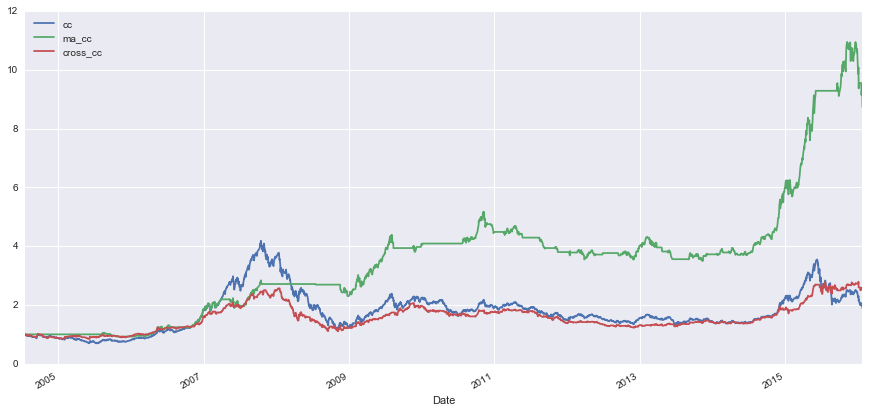

In [284]:
(1+ret).cumprod().plot(figsize=[15,7])

## 结果分析
根据上述的策略回报曲线，可以看出将RPS与单边波动率相结合，可以产生更稳定的市场择时信号。各种组合中，以ma_cc的回报率最高：

In [270]:
ret.groupby(ret.index.year).sum()

,cc,ma_cc,cross_cc
2004,-0.129126,0.000000,-0.125926
2005,-0.064258,-0.074665,0.083353
2006,0.858145,0.715673,0.544992
2007,0.737125,0.417093,0.464227
2008,-0.959211,-0.157301,-0.657279
2009,0.632530,0.600824,0.505891
2010,-0.130191,0.102449,-0.102280
2011,-0.227903,-0.161723,-0.220043
2012,0.045705,0.063358,-0.054383
2013,-0.053905,-0.066719,0.083380
